In [264]:
import os
import scipy.io

training_dir = os.path.join('..', 'data', 'training')

training_data = {'normal': [], 'af': []}
max_len = 9000

for Class in ['normal', 'af']:
    class_dir = os.path.join(training_dir, Class)
    for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
        mat_data = scipy.io.loadmat(file)
        sequence = mat_data['val'][0]
        if len(sequence) >= 9000:
          normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
          padded_sequence = normalised_sequence[:max_len]
          training_data[Class].append(padded_sequence)

validation_dir = os.path.join('..', 'data', 'validation')

validation_data = {'normal': [], 'af': []}
max_len = 9000

for Class in ['normal', 'af']:
    class_dir = os.path.join(validation_dir, Class)
    for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
        mat_data = scipy.io.loadmat(file)
        sequence = mat_data['val'][0]
        if len(sequence) >= 9000:
          normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
          padded_sequence = normalised_sequence[:max_len]
          validation_data[Class].append(padded_sequence)


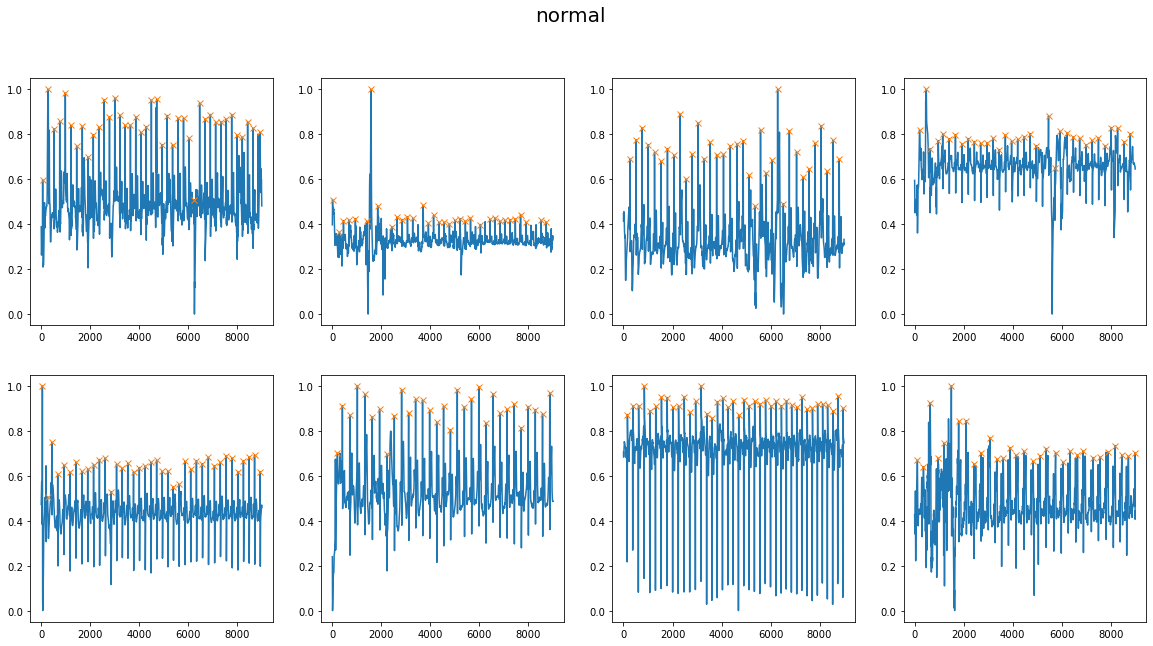

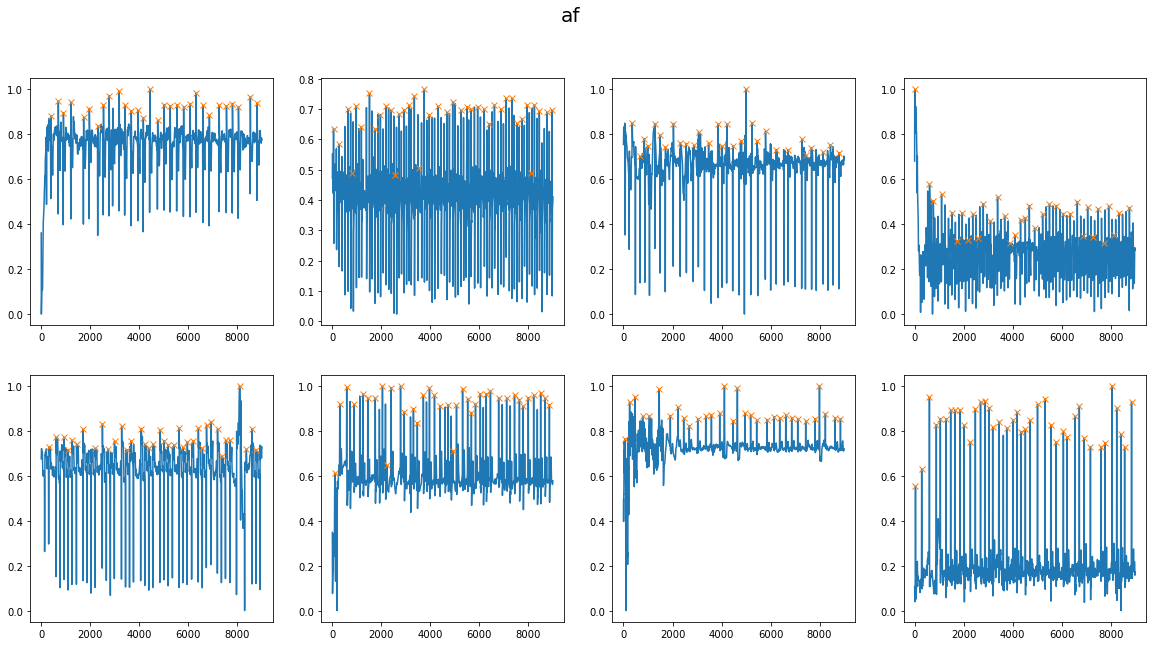

In [61]:
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import random

fig, axs = plt.subplots(2, 4)
fig.set_size_inches(20, 10)

random.shuffle(training_data['normal'])

for i in range(8):
    x = training_data['normal'][i]
    peaks, _ = scipy.signal.find_peaks(x, distance=150, prominence=0.1)
    axs[int((i/4) % 2), i%4].plot(x)
    axs[int((i/4) % 2), i%4].plot(peaks, x[peaks], "x")
    fig.suptitle('normal', fontsize=20)

fig, axs = plt.subplots(2, 4)
fig.set_size_inches(20, 10)

random.shuffle(training_data['af'])

for i in range(8):
    x = training_data['af'][i]
    peaks, _ = scipy.signal.find_peaks(x, distance=150, prominence=0.1)
    axs[int((i/4) % 2), i%4].plot(x)
    axs[int((i/4) % 2), i%4].plot(peaks, x[peaks], "x")
    fig.suptitle('af', fontsize=20)

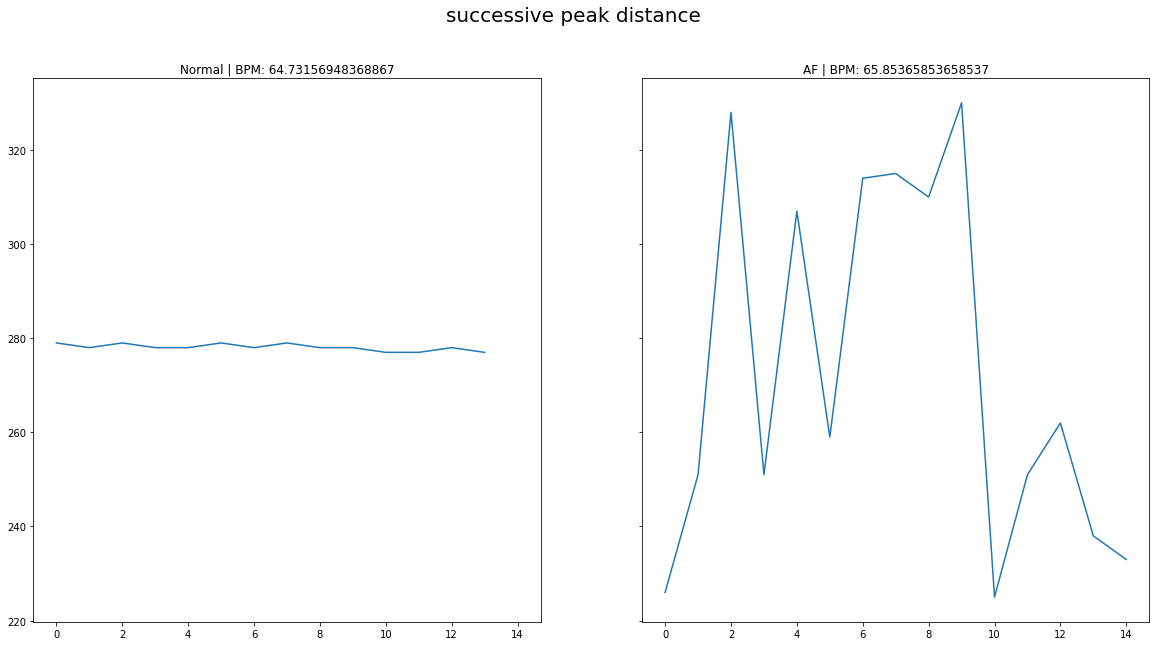

In [149]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(20, 10)

def get_successive_peak_distances(peaks):
    for i in range(len(peaks)-1):
        yield peaks[i+1]-peaks[i]
        
fig.suptitle('successive peak distance', fontsize=20)
        
x = training_data['normal'][random.randint(0, len(training_data['normal'])-1)]
peaks, _ = scipy.signal.find_peaks(x, distance=150, prominence=0.1)
peak_distances = np.array(list(get_successive_peak_distances(peaks)))
q75, q25 = np.percentile(peak_distances, [75 ,25])
peak_distances = peak_distances[peak_distances >= q25]
peak_distances = peak_distances[peak_distances <= q75]


axs[0].plot(peak_distances)
axs[0].title.set_text(f"Normal | BPM: {(300/np.mean(peak_distances))*60}")

x = training_data['af'][random.randint(0, len(training_data['af'])-1)]
peaks, _ = scipy.signal.find_peaks(x, distance=150, prominence=0.1)
peak_distances = np.array(list(get_successive_peak_distances(peaks)))
q75, q25 = np.percentile(peak_distances, [75 ,25])
peak_distances = peak_distances[peak_distances >= q25]
peak_distances = peak_distances[peak_distances <= q75]

axs[1].plot(peak_distances)
axs[1].title.set_text(f"AF | BPM: {(300/np.mean(peak_distances))*60}")

Text(0.5, 1.0, 'QRS distance variance PDFs')

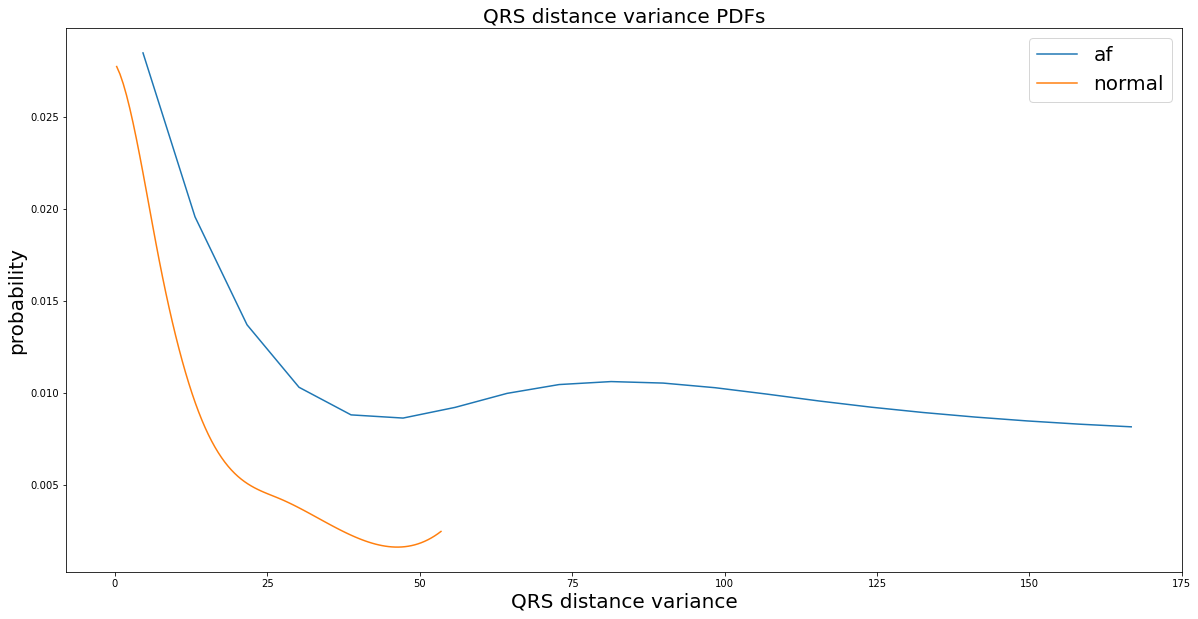

In [324]:
from scipy.interpolate import UnivariateSpline

normal_pd_variances = []
af_pd_variances = []

for x in training_data['normal']:
    peaks, _ = scipy.signal.find_peaks(x, distance=150, prominence=0.1)
    if len(peaks) > 20:
        peak_distances = np.array(list(get_successive_peak_distances(peaks)))
        q75, q25 = np.percentile(peak_distances, [75 ,25])
        peak_distances = peak_distances[peak_distances >= q25]
        peak_distances = peak_distances[peak_distances <= q75]
        normal_pd_variances.append(np.var(peak_distances))

for x in training_data['af']:
    peaks, _ = scipy.signal.find_peaks(x, distance=150, prominence=0.1)
    if len(peaks) > 20:
        peak_distances = np.array(list(get_successive_peak_distances(peaks)))
        q75, q25 = np.percentile(peak_distances, [75 ,25])
        peak_distances = peak_distances[peak_distances >= q25]
        peak_distances = peak_distances[peak_distances <= q75]
        af_pd_variances.append(np.var(peak_distances))

fig, axs = plt.subplots(1)
fig.set_size_inches(20, 10)

q75, q25 = np.percentile(af_pd_variances, [75 ,25])
af_pd_variances = np.array(af_pd_variances)[af_pd_variances <= q75]

p, x = np.histogram(af_pd_variances, bins=100)
x = x[:-1] + (x[1] - x[0])/2
f = UnivariateSpline(x, p, s=500)
pdf_af = f(x) / len(training_data['af'])
axs.plot(x[:20], pdf_af[:20], label='af')

q75, q25 = np.percentile(normal_pd_variances, [75 ,25])
normal_pd_variances = np.array(normal_pd_variances)[normal_pd_variances <= q75]

p, x = np.histogram(normal_pd_variances, bins=100)
x = x[:-1] + (x[1] - x[0])/2
f = UnivariateSpline(x, p, s=10000)
pdf_normal = f(x) / len(training_data['normal'])
axs.plot(x, pdf_normal, label='normal')

axs.legend(fontsize=20)
axs.set_xlabel('QRS distance variance', fontsize=20)
axs.set_ylabel('probability', fontsize=20)
axs.set_title('QRS distance variance PDFs', fontsize=20)

In [329]:
def predict(data):
    for x in data:
        peaks, _ = scipy.signal.find_peaks(x, distance=150, prominence=0.1)
        if len(peaks) > 20:
            peak_distances = np.array(list(get_successive_peak_distances(peaks)))
            q75, q25 = np.percentile(peak_distances, [75 ,25])
            peak_distances = peak_distances[peak_distances >= q25]
            peak_distances = peak_distances[peak_distances <= q75]
            if np.var(peak_distances) > 40:
                yield('af')
            else:
                yield('normal')
        else:
            yield('unknown')

validation_x = np.concatenate((validation_data['normal'], validation_data['af']))
validation_y = np.concatenate((['normal']*len(validation_data['normal']),['af']*len(validation_data['af'])))

idx = np.random.permutation(len(validation_x))
validation_x = validation_x[idx]
validation_y = validation_y[idx]

prediction = list(predict(validation_x))

confusion_matrix = {'l_af_p_af': 0, 'l_af_p_normal': 0, 'l_normal_p_normal': 0, 'l_normal_p_af': 0}

for p, l in zip(prediction, validation_y):
    if l == 'af' and p == 'af':
        confusion_matrix['l_af_p_af'] += 1
    elif l == 'af' and p == 'normal':
        confusion_matrix['l_af_p_normal'] += 1
    elif l == 'normal' and p == 'normal':
        confusion_matrix['l_normal_p_normal'] += 1
    elif l == 'normal' and p == 'af':
        confusion_matrix['l_normal_p_af'] += 1

print(confusion_matrix, '\n')
false_negative_rate = 100 * confusion_matrix['l_af_p_normal'] / len(validation_data['af'])
false_positive_rate = 100 * confusion_matrix['l_normal_p_af'] / len(validation_data['normal'])
acc = 100 - ((false_negative_rate+false_positive_rate)/2)

print('false negative rate:', false_negative_rate)
print('false positive rate:', false_positive_rate)
print('accuracy:', acc)

{'l_af_p_af': 40, 'l_af_p_normal': 3, 'l_normal_p_normal': 87, 'l_normal_p_af': 45} 

false negative rate: 6.976744186046512
false positive rate: 33.582089552238806
accuracy: 79.72058313085734
